# Artificial Neural Networks and Deep Learning

---

## Homework 2: Bio.log(y)

### Model 5: U-Net++ with Transformer-based Feature Fusion and Multi-Scale Transformers

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.saving import register_keras_serializable


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load the Data

In [2]:
# Load the compressed dataset
data = np.load("/kaggle/input/mydatasets-base/mars_datasets_base.npz")

# Extract the individual arrays
X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]
X_our_test = data["X_our_test"]
y_our_test = data["y_our_test"]
X_test = data["X_test"]

# Print shapes to verify successful loading
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_our_test shape: {X_our_test.shape}")
print(f"y_our_test shape: {y_our_test.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1503, 64, 128, 1)
y_train shape: (1503, 64, 128)
X_val shape: (501, 64, 128, 1)
y_val shape: (501, 64, 128)
X_our_test shape: (501, 64, 128, 1)
y_our_test shape: (501, 64, 128)
X_test shape: (10022, 64, 128, 1)


## 🛠️ Train and Save the Model

In [3]:
input_shape = (64, 128, 1)
num_classes = len(np.unique(y_train))

In [4]:
# Number of training epochs
epochs = 200

# Batch size for training
batch_size = 32

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)

Epochs: 200
Batch Size: 32


In [5]:
def create_segmentation_colormap(num_classes):
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    label = np.asarray(label).squeeze()

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

In [6]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, num_classes, frequency=5):
        super().__init__()
        self.image = image
        self.label = label  # Assumiamo che `label` sia già un array NumPy
        self.num_classes = num_classes
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualizza solo ogni "frequency" epoche
            pred = self.model.predict(tf.expand_dims(self.image, axis=0), verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1).numpy()

            # Create colormap
            colormap = create_segmentation_colormap(self.num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(self.image.squeeze(), cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(self.label, colormap)  # Rimosso `.numpy()`
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [8]:
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])

    # Exclude the background class
    y_true = y_true[..., 1:]
    y_pred = y_pred[..., 1:]

    # Clip predictions
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

    # Focal loss
    cross_entropy = -y_true * tf.math.log(y_pred)
    weights = alpha * tf.math.pow(1 - y_pred, gamma)
    loss = weights * cross_entropy
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

def dice_loss(y_true, y_pred, smooth=1e-6):

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)

    # Exclude the background class
    y_true = y_true[..., 1:]
    y_pred = y_pred[..., 1:]

    # Intersection and union
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2])

    # Dice loss
    dice = 1 - (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

def combined_loss(y_true, y_pred, dice_weight=0.5, focal_weight=0.5):
    d_loss = dice_loss(y_true, y_pred)
    f_loss = focal_loss(y_true, y_pred)
    return focal_weight * f_loss + dice_weight * d_loss

In [9]:
@register_keras_serializable()  # Optional: Simplifies future model loading
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, name='transformer_block', **kwargs):
        super(TransformerBlock, self).__init__(name=name, **kwargs)
        self.att = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name=name+'_mha')
        self.ffn = tf.keras.Sequential([
            tfkl.Dense(ff_dim, activation='relu', name=name+'_ffn_dense1'),
            tfkl.Dense(embed_dim, name=name+'_ffn_dense2'),
        ], name=name+'_ffn')
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6, name=name+'_ln1')
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6, name=name+'_ln2')
        self.dropout1 = tfkl.Dropout(rate, name=name+'_dropout1')
        self.dropout2 = tfkl.Dropout(rate, name=name+'_dropout2')

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)  # Self-attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Residual connection

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # Residual connection

In [10]:
def residual_block(x, filters, kernel_size=3, activation='relu', name=''):
    """A residual block with two convolutions, group normalization, and a skip connection."""
    skip = x
    # First convolution
    x = tfkl.Conv2D(filters, kernel_size, padding='same', name=name+'conv1')(x)
    x = tfkl.GroupNormalization(groups=8, axis=-1, name=name+'gn1')(x)
    x = tfkl.Activation(activation, name=name+'act1')(x)

    # Second convolution
    x = tfkl.Conv2D(filters, kernel_size, padding='same', name=name+'conv2')(x)
    x = tfkl.GroupNormalization(groups=8, axis=-1, name=name+'gn2')(x)

    # Adjust skip connection if necessary
    if skip.shape[-1] != filters:
        skip = tfkl.Conv2D(filters, 1, padding='same', name=name+'conv_skip')(skip)
        skip = tfkl.GroupNormalization(groups=8, axis=-1, name=name+'gn_skip')(skip)

    # Add skip connection
    x = tfkl.Add(name=name+'add')([x, skip])
    x = tfkl.Activation(activation, name=name+'act2')(x)
    return x

In [11]:
def attention_gate(x, g, filters, name=''):
    """An attention gate that highlights relevant features from the skip connection x using the gating signal g."""
    # Project x and g
    x_proj = tfkl.Conv2D(filters, 1, padding='same', name=name+'x_proj')(x)
    g_proj = tfkl.Conv2D(filters, 1, padding='same', name=name+'g_proj')(g)

    # Combine projections
    combined = tfkl.Add(name=name+'add')([x_proj, g_proj])
    combined = tfkl.Activation('relu', name=name+'relu')(combined)

    # Compute attention coefficients
    attn = tfkl.Conv2D(1, 1, padding='same', name=name+'attn_conv')(combined)
    attn = tfkl.Activation('sigmoid', name=name+'attn_sigmoid')(attn)

    # Multiply attention coefficients with the skip connection
    x = tfkl.Multiply(name=name+'attn_mul')([x, attn])
    return x

In [12]:
def multi_scale_bottleneck(x, filters, activation='relu', name=''):
    """Multi-scale context with parallel dilated convolutions."""
    # Dilated convolutions with different rates
    x1 = tfkl.Conv2D(filters, 3, padding='same', dilation_rate=1, name=name+'dil1_conv')(x)
    x1 = tfkl.GroupNormalization(groups=8, axis=-1, name=name+'dil1_gn')(x1)
    x1 = tfkl.Activation(activation, name=name+'dil1_act')(x1)

    x2 = tfkl.Conv2D(filters, 3, padding='same', dilation_rate=2, name=name+'dil2_conv')(x)
    x2 = tfkl.GroupNormalization(groups=8, axis=-1, name=name+'dil2_gn')(x2)
    x2 = tfkl.Activation(activation, name=name+'dil2_act')(x2)

    x3 = tfkl.Conv2D(filters, 3, padding='same', dilation_rate=4, name=name+'dil3_conv')(x)
    x3 = tfkl.GroupNormalization(groups=8, axis=-1, name=name+'dil3_gn')(x3)
    x3 = tfkl.Activation(activation, name=name+'dil3_act')(x3)

    # Concatenate the outputs
    x_cat = tfkl.Concatenate(name=name+'concat')([x1, x2, x3])

    # Compress back to the original number of filters
    x_out = tfkl.Conv2D(filters, 1, padding='same', name=name+'compress_conv')(x_cat)
    x_out = tfkl.GroupNormalization(groups=8, axis=-1, name=name+'compress_gn')(x_out)
    x_out = tfkl.Activation(activation, name=name+'compress_act')(x_out)

    return x_out

In [13]:
def adaptive_fusion(x1, x2, name=''):
    """Adaptive feature fusion using gating mechanism."""
    # Concatenate the two feature maps
    concat = tfkl.Concatenate(name=name+'concat')([x1, x2])

    # Compute gating coefficients
    gate = tfkl.Conv2D(1, 1, padding='same', name=name+'gate_conv')(concat)
    gate = tfkl.Activation('sigmoid', name=name+'gate_sigmoid')(gate)

    # Fuse the feature maps
    fused = tfkl.Multiply(name=name+'fused_mul')([concat, gate])

    return fused

In [14]:
def get_unet_plus_plus_transformer_model(input_shape=(64,128,1), num_classes=5, activation='relu', seed=42):
    """
    Builds a U-Net++ model with Transformer-based Feature Fusion and Multi-Scale Transformers.
    """
    if seed is not None:
        tf.random.set_seed(seed)

    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    # Encoder
    # Level 1
    f1 = residual_block(inputs, 64, name='enc1_')
    p1 = tfkl.MaxPooling2D((2,2), name='pool1')(f1)

    # Level 2
    f2 = residual_block(p1, 128, name='enc2_')
    p2 = tfkl.MaxPooling2D((2,2), name='pool2')(f2)

    # Level 3
    f3 = residual_block(p2, 256, name='enc3_')
    p3 = tfkl.MaxPooling2D((2,2), name='pool3')(f3)

    # Bottleneck with multi-scale context
    b = residual_block(p3, 512, name='bottleneck_pre_')
    b = multi_scale_bottleneck(b, 512, name='bottleneck_ms_')
    b = residual_block(b, 512, name='bottleneck_post_')

    # Transformer Block at Bottleneck
    transformer = TransformerBlock(embed_dim=512, num_heads=8, ff_dim=1024, name='transformer_bottleneck')(b)

    # Decoder
    # Level 3
    u3 = tfkl.UpSampling2D((2,2), name='up3')(transformer)
    attn3 = attention_gate(f3, u3, filters=256, name='attn3_')
    concat3 = tfkl.Concatenate(name='concat3')([u3, attn3])
    dec3 = residual_block(concat3, 256, name='dec3_')

    # Feature Fusion at Decoder Level 3
    # Introduce nested connections
    dec3_1 = residual_block(dec3, 256, name='dec3_1_')
    fuse3 = adaptive_fusion(dec3, dec3_1, name='fuse3')

    # Level 2
    u2 = tfkl.UpSampling2D((2,2), name='up2')(fuse3)
    attn2 = attention_gate(f2, u2, filters=128, name='attn2_')
    concat2 = tfkl.Concatenate(name='concat2')([u2, attn2])
    dec2 = residual_block(concat2, 128, name='dec2_')

    # Feature Fusion at Decoder Level 2
    dec2_1 = residual_block(dec2, 128, name='dec2_1_')
    fuse2 = adaptive_fusion(dec2, dec2_1, name='fuse2')

    # Level 1
    u1 = tfkl.UpSampling2D((2,2), name='up1')(fuse2)
    attn1 = attention_gate(f1, u1, filters=64, name='attn1_')
    concat1 = tfkl.Concatenate(name='concat1')([u1, attn1])
    dec1 = residual_block(concat1, 64, name='dec1_')

    # Feature Fusion at Decoder Level 1
    dec1_1 = residual_block(dec1, 64, name='dec1_1_')
    fuse1 = adaptive_fusion(dec1, dec1_1, name='fuse1')

    # Output layer
    output_layer = tfkl.Conv2D(num_classes, (1,1), activation='softmax', name='output_layer')(fuse1)

    # Final model
    model = tf.keras.Model(inputs, output_layer, name='UNetPlusPlus_Transformer')
    return model

Model: "UNetPlusPlus_Transformer"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_conv1        │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_gn1          │ (None, 64, 128, │       128 │ enc1_conv1[0]… │   Y   │
│ (GroupNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_act1         │ (None, 64, 128, │         0 │ enc1_gn1[0][0] │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_conv2        │ (None, 64, 128, │    36,928 │ enc1_act1[0][… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_conv_skip    │ (None, 64, 128, │       128 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_gn2          │ (None, 64, 128, │       128 │ enc1_conv2[0]… │   Y   │
│ (GroupNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_gn_skip      │ (None, 64, 128, │       128 │ enc1_conv_ski… │   Y   │
│ (GroupNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_add (Add)    │ (None, 64, 128, │         0 │ enc1_gn2[0][0… │   -   │
│                   │ 64)             │           │ enc1_gn_skip[… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_act2         │ (None, 64, 128, │         0 │ enc1_add[0][0] │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1             │ (None, 32, 64,  │         0 │ enc1_act2[0][… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_conv1        │ (None, 32, 64,  │    73,856 │ pool1[0][0]    │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_gn1          │ (None, 32, 64,  │       256 │ enc2_conv1[0]… │   Y   │
│ (GroupNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_act1         │ (None, 32, 64,  │         0 │ enc2_gn1[0][0] │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_conv2        │ (None, 32, 64,  │   147,584 │ enc2_act1[0][… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_conv_skip    │ (None, 32, 64,  │     8,320 │ pool1[0][0]    │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_gn2          │ (None, 32, 64,  │       256 │ enc2_conv2[0]… │   Y 

 Total params: 32,529,867 (124.09 MB)

 Trainable params: 32,529,867 (124.09 MB)

 Non-trainable params: 0 (0.00 B)

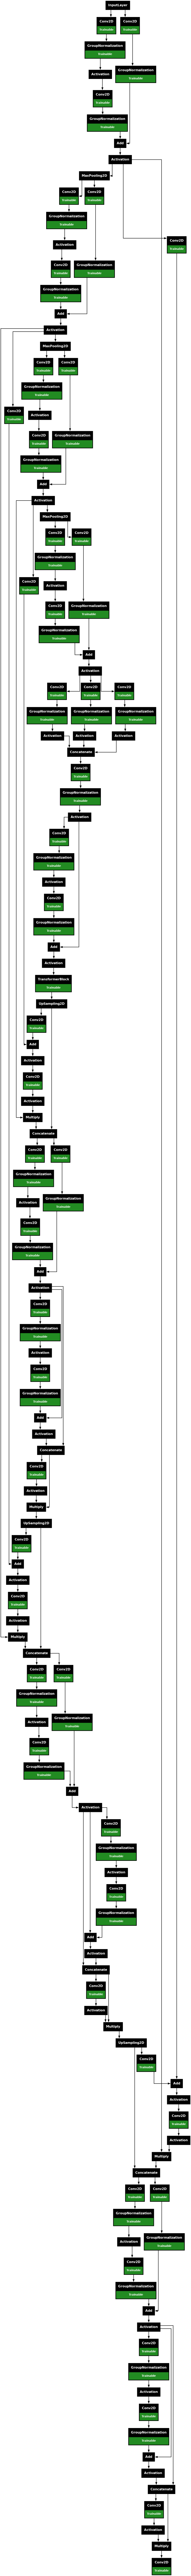

In [15]:
model = get_unet_plus_plus_transformer_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [16]:
model.compile(optimizer="adam",
              loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, dice_weight=0.2, focal_weight=0.8),
              metrics=["accuracy",
                       MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])])

model.summary()

Model: "UNetPlusPlus_Transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv1 (Conv2D) │ (None, 64, 128,   │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_gn1            │ (None, 64, 128,   │        128 │ enc1_conv1[0][0]  │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_act1           │ (None, 64, 128,   │          0 │ enc1_gn1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv2 (Conv2D) │ (None, 64, 128,   │     36,928 │ enc1_act1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv_skip      │ (None, 64, 128,   │        128 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_gn2            │ (None, 64, 128,   │        128 │ enc1_conv2[0][0]  │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_gn_skip        │ (None, 64, 128,   │        128 │ enc1_conv_skip[0… │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_add (Add)      │ (None, 64, 128,   │          0 │ enc1_gn2[0][0],   │
│                     │ 64)               │            │ enc1_gn_skip[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_act2           │ (None, 64, 128,   │          0 │ enc1_add[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 64,    │          0 │ enc1_act2[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_conv1 (Conv2D) │ (None, 32, 64,    │     73,856 │ pool1[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_gn1            │ (None, 32, 64,    │        256 │ enc2_conv1[0][0]  │
│ (GroupNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_act1           │ (None, 32, 64,    │          0 │ enc2_gn1[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_conv2 (Conv2D) │ (None, 32, 64,    │    147,584 │ enc2_act1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_conv_skip      │ (None, 32, 64,    │      8,320 │ pool1[0][0]       │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_gn2            │ (None, 32, 64,    │        256 │ enc2_conv2[0][0]

 Total params: 32,529,867 (124.09 MB)

 Trainable params: 32,529,867 (124.09 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=20,
    restore_best_weights=True
)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Select a specific image and mask from the dataset
sample_idx = 42
sample_image = X_train[sample_idx]
sample_mask = y_train[sample_idx]

# Initialize the VizCallback with the selected image and mask
viz_callback = VizCallback(
    image=sample_image,
    label=sample_mask,
    num_classes=num_classes,
    frequency=5
)

Epoch 1/200


I0000 00:00:1734196952.108577    3987 service.cc:145] XLA service 0x7cc340029b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734196952.108632    3987 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734196952.108637    3987 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734196969.805464    4027 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_33', 1800 bytes spill stores, 1800 bytes spill loads

I0000 00:00:1734196972.761864    4026 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 1348 bytes spill stores, 1348 bytes spill loads

I0000 00:00:1734196975.286897    4024 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_34', 1384 bytes spill stores, 1384 bytes spill loads

I0000 00:00:

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.3173 - loss: 0.2900 - mean_iou: 0.1085

I0000 00:00:1734197101.415588    4114 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_33', 1800 bytes spill stores, 1800 bytes spill loads

I0000 00:00:1734197102.244292    4113 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_32', 1384 bytes spill stores, 1384 bytes spill loads

I0000 00:00:1734197109.285682    4113 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 768 bytes spill stores, 768 bytes spill loads

I0000 00:00:1734197111.055910    4116 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 768 bytes spill stores, 768 bytes spill loads

I0000 00:00:1734197112.703111    4114 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 1348 bytes spill stores, 1348 bytes spill loads

I0000 00:00:1734197119.655696

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3175 - loss: 0.2894 - mean_iou: 0.1088   

I0000 00:00:1734197201.347559    4184 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 768 bytes spill stores, 768 bytes spill loads

I0000 00:00:1734197201.663783    4185 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 768 bytes spill stores, 768 bytes spill loads



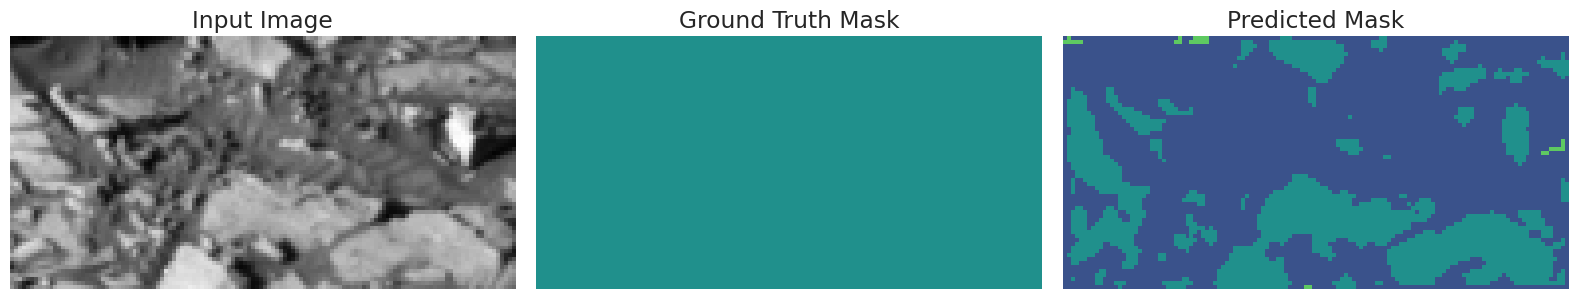

47/47 ━━━━━━━━━━━━━━━━━━━━ 294s 4s/step - accuracy: 0.3178 - loss: 0.2887 - mean_iou: 0.1092 - val_accuracy: 0.3701 - val_loss: 0.2498 - val_mean_iou: 0.1634 - learning_rate: 0.0010
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 31s 655ms/step - accuracy: 0.3637 - loss: 0.2429 - mean_iou: 0.2016 - val_accuracy: 0.3708 - val_loss: 0.2622 - val_mean_iou: 0.1920 - learning_rate: 0.0010
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 627ms/step - accuracy: 0.4058 - loss: 0.2380 - mean_iou: 0.2587 - val_accuracy: 0.3954 - val_loss: 0.2531 - val_mean_iou: 0.2109 - learning_rate: 0.0010
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 618ms/step - accuracy: 0.4297 - loss: 0.2333 - mean_iou: 0.2851 - val_accuracy: 0.3979 - val_loss: 0.2525 - val_mean_iou: 0.2185 - learning_rate: 0.0010
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 635ms/step - accuracy: 0.4623 - loss: 0.2262 - mean_iou: 0.3253 - val_accuracy: 0.4163 - val_loss: 0.2428 - val_mean_iou: 0.2468 - learning_rate: 0.0010
Epoch 6/200
47/47 ━━━━━━━━━━━━━━━━

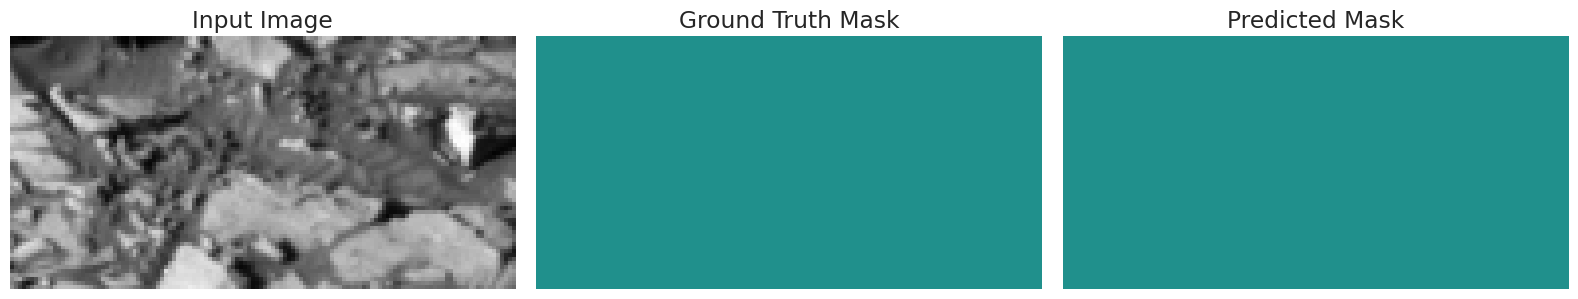

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 638ms/step - accuracy: 0.4778 - loss: 0.2209 - mean_iou: 0.3444 - val_accuracy: 0.4249 - val_loss: 0.2428 - val_mean_iou: 0.2510 - learning_rate: 0.0010
Epoch 7/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 625ms/step - accuracy: 0.4843 - loss: 0.2194 - mean_iou: 0.3524 - val_accuracy: 0.4567 - val_loss: 0.2379 - val_mean_iou: 0.2788 - learning_rate: 0.0010
Epoch 8/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step - accuracy: 0.5052 - loss: 0.2147 - mean_iou: 0.3779 - val_accuracy: 0.5021 - val_loss: 0.2191 - val_mean_iou: 0.3513 - learning_rate: 0.0010
Epoch 9/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 634ms/step - accuracy: 0.5350 - loss: 0.2074 - mean_iou: 0.4156 - val_accuracy: 0.5113 - val_loss: 0.2174 - val_mean_iou: 0.3529 - learning_rate: 0.0010
Epoch 10/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 634ms/step - accuracy: 0.5597 - loss: 0.2040 - mean_iou: 0.4467 - val_accuracy: 0.5668 - val_loss: 0.2039 - val_mean_iou: 0.4451 - learning_rate: 0.0010
Epoch 11/200
47/47 ━━━━━━━━━━━━

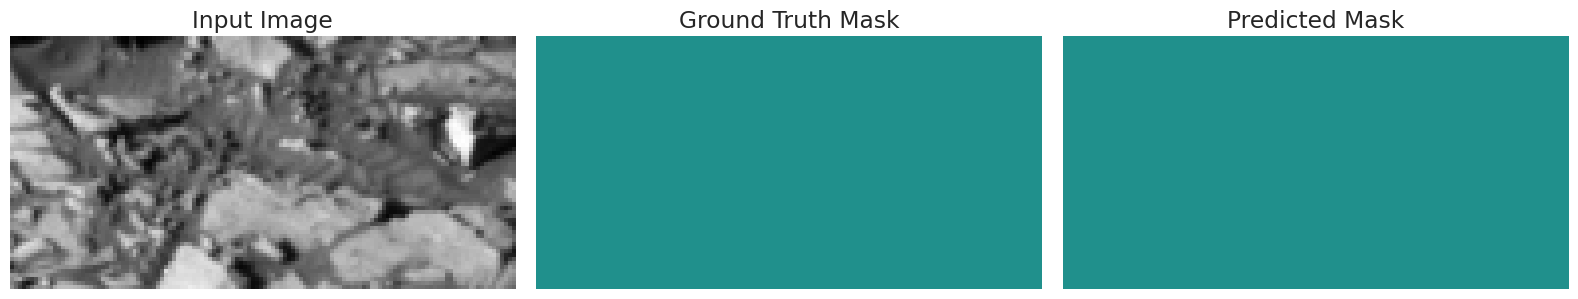

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 645ms/step - accuracy: 0.5675 - loss: 0.2006 - mean_iou: 0.4623 - val_accuracy: 0.5790 - val_loss: 0.2001 - val_mean_iou: 0.4624 - learning_rate: 0.0010
Epoch 12/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 629ms/step - accuracy: 0.5928 - loss: 0.1963 - mean_iou: 0.4929 - val_accuracy: 0.5801 - val_loss: 0.1999 - val_mean_iou: 0.4666 - learning_rate: 0.0010
Epoch 13/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 628ms/step - accuracy: 0.5898 - loss: 0.1961 - mean_iou: 0.4873 - val_accuracy: 0.5737 - val_loss: 0.1989 - val_mean_iou: 0.4595 - learning_rate: 0.0010
Epoch 14/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 630ms/step - accuracy: 0.6021 - loss: 0.1939 - mean_iou: 0.5063 - val_accuracy: 0.5866 - val_loss: 0.1980 - val_mean_iou: 0.4751 - learning_rate: 0.0010
Epoch 15/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 630ms/step - accuracy: 0.6017 - loss: 0.1940 - mean_iou: 0.5062 - val_accuracy: 0.5873 - val_loss: 0.1987 - val_mean_iou: 0.4757 - learning_rate: 0.0010
Epoch 16/200
47/47 ━━━━━━━━━

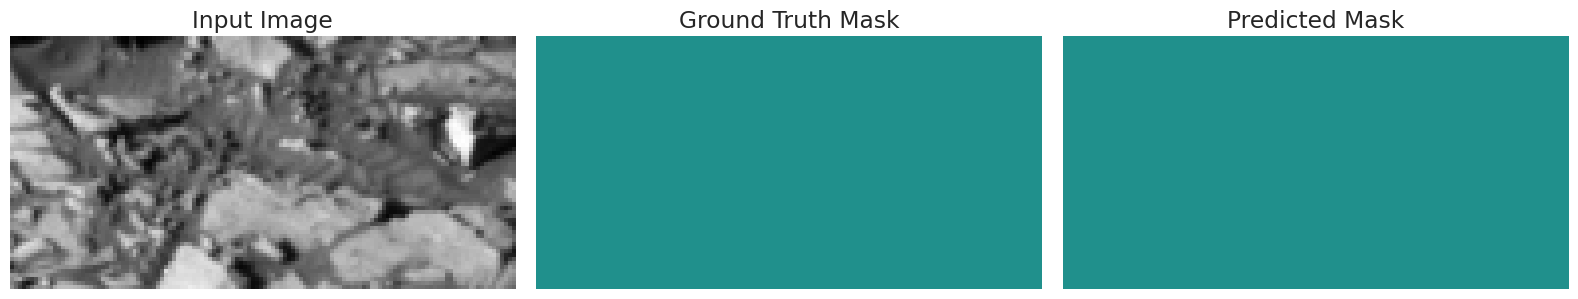

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 640ms/step - accuracy: 0.5956 - loss: 0.1949 - mean_iou: 0.4985 - val_accuracy: 0.6034 - val_loss: 0.1940 - val_mean_iou: 0.4947 - learning_rate: 0.0010
Epoch 17/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 629ms/step - accuracy: 0.6113 - loss: 0.1923 - mean_iou: 0.5194 - val_accuracy: 0.6101 - val_loss: 0.1940 - val_mean_iou: 0.5032 - learning_rate: 0.0010
Epoch 18/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 630ms/step - accuracy: 0.6076 - loss: 0.1925 - mean_iou: 0.5146 - val_accuracy: 0.6149 - val_loss: 0.1920 - val_mean_iou: 0.5085 - learning_rate: 0.0010
Epoch 19/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 631ms/step - accuracy: 0.6107 - loss: 0.1917 - mean_iou: 0.5184 - val_accuracy: 0.6213 - val_loss: 0.1921 - val_mean_iou: 0.5161 - learning_rate: 0.0010
Epoch 20/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 628ms/step - accuracy: 0.6150 - loss: 0.1913 - mean_iou: 0.5251 - val_accuracy: 0.6123 - val_loss: 0.1936 - val_mean_iou: 0.5018 - learning_rate: 0.0010
Epoch 21/200
47/47 ━━━━━━━━━

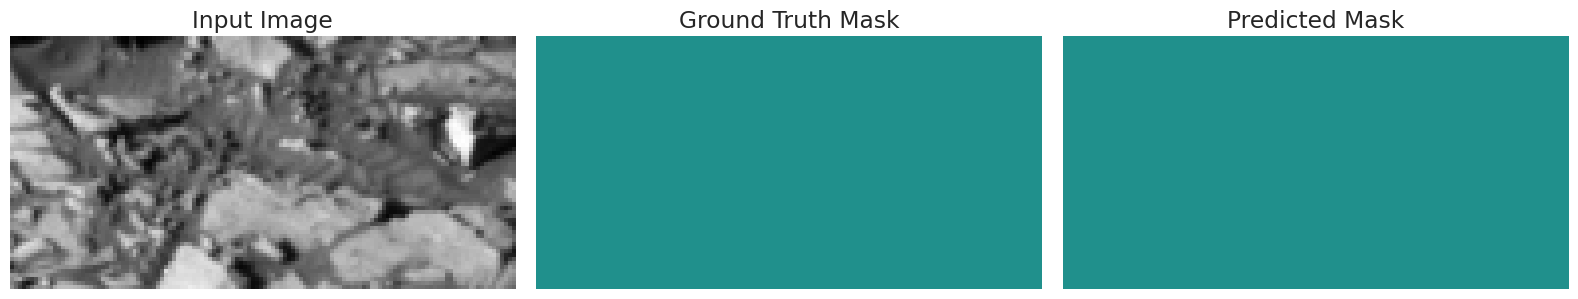

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 638ms/step - accuracy: 0.6192 - loss: 0.1906 - mean_iou: 0.5304 - val_accuracy: 0.6100 - val_loss: 0.1941 - val_mean_iou: 0.5001 - learning_rate: 0.0010
Epoch 22/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 629ms/step - accuracy: 0.6178 - loss: 0.1907 - mean_iou: 0.5285 - val_accuracy: 0.6225 - val_loss: 0.1912 - val_mean_iou: 0.5198 - learning_rate: 0.0010
Epoch 23/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 626ms/step - accuracy: 0.6184 - loss: 0.1899 - mean_iou: 0.5299 - val_accuracy: 0.6026 - val_loss: 0.1952 - val_mean_iou: 0.4904 - learning_rate: 0.0010
Epoch 24/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 628ms/step - accuracy: 0.6220 - loss: 0.1890 - mean_iou: 0.5351 - val_accuracy: 0.6173 - val_loss: 0.1915 - val_mean_iou: 0.5134 - learning_rate: 0.0010
Epoch 25/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 628ms/step - accuracy: 0.6303 - loss: 0.1876 - mean_iou: 0.5471 - val_accuracy: 0.6072 - val_loss: 0.1935 - val_mean_iou: 0.4992 - learning_rate: 0.0010
Epoch 26/200
47/47 ━━━━━━━━━

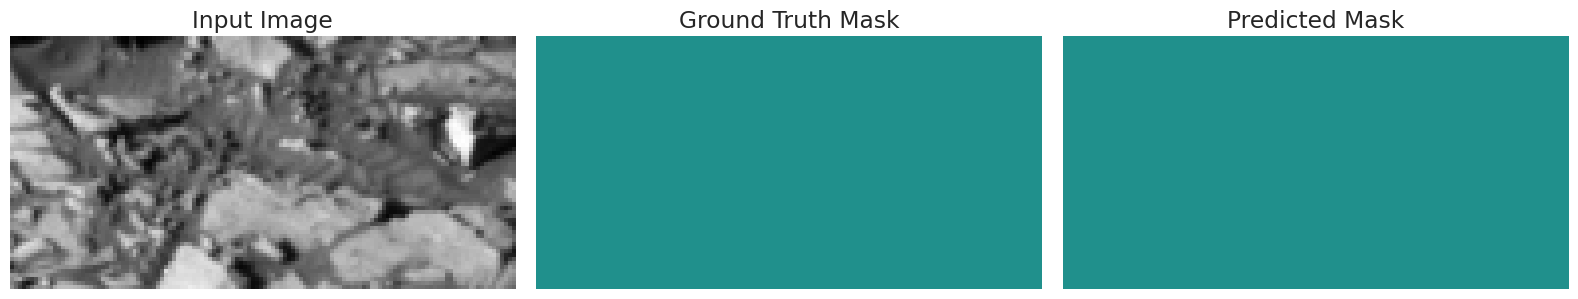

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 642ms/step - accuracy: 0.6238 - loss: 0.1896 - mean_iou: 0.5381 - val_accuracy: 0.6183 - val_loss: 0.1913 - val_mean_iou: 0.5125 - learning_rate: 0.0010
Epoch 27/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.6272 - loss: 0.1869 - mean_iou: 0.5456
Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 629ms/step - accuracy: 0.6274 - loss: 0.1869 - mean_iou: 0.5455 - val_accuracy: 0.6046 - val_loss: 0.1943 - val_mean_iou: 0.4991 - learning_rate: 0.0010
Epoch 28/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 639ms/step - accuracy: 0.6228 - loss: 0.1879 - mean_iou: 0.5368 - val_accuracy: 0.6307 - val_loss: 0.1894 - val_mean_iou: 0.5406 - learning_rate: 5.0000e-04
Epoch 29/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 630ms/step - accuracy: 0.6406 - loss: 0.1831 - mean_iou: 0.5692 - val_accuracy: 0.6378 - val_loss: 0.1876 - val_mean_iou: 0.5515 - learning_rate: 5.0000e-04
Epoch 30/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 63

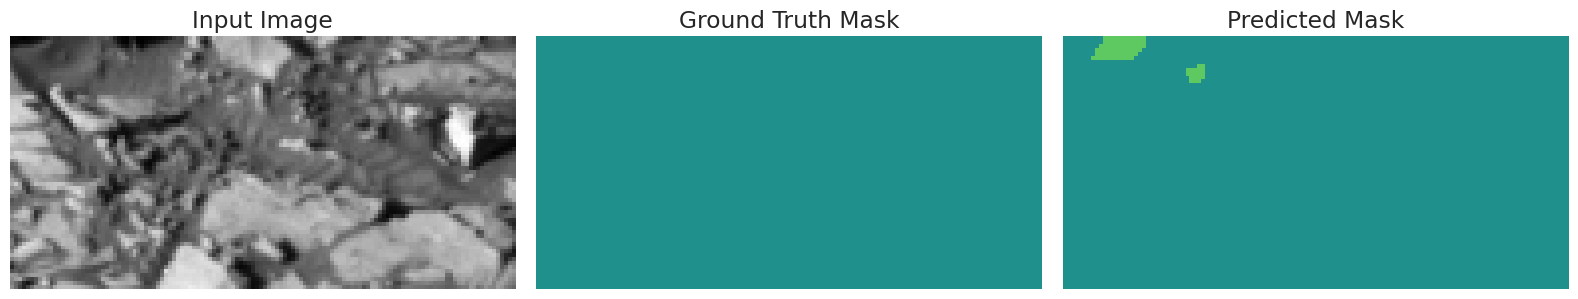

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 643ms/step - accuracy: 0.6458 - loss: 0.1815 - mean_iou: 0.5776 - val_accuracy: 0.6438 - val_loss: 0.1866 - val_mean_iou: 0.5627 - learning_rate: 5.0000e-04
Epoch 32/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 627ms/step - accuracy: 0.6474 - loss: 0.1810 - mean_iou: 0.5800 - val_accuracy: 0.6431 - val_loss: 0.1866 - val_mean_iou: 0.5590 - learning_rate: 5.0000e-04
Epoch 33/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step - accuracy: 0.6478 - loss: 0.1808 - mean_iou: 0.5807 - val_accuracy: 0.6431 - val_loss: 0.1866 - val_mean_iou: 0.5632 - learning_rate: 5.0000e-04
Epoch 34/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 633ms/step - accuracy: 0.6489 - loss: 0.1803 - mean_iou: 0.5827 - val_accuracy: 0.6439 - val_loss: 0.1861 - val_mean_iou: 0.5622 - learning_rate: 5.0000e-04
Epoch 35/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 634ms/step - accuracy: 0.6494 - loss: 0.1800 - mean_iou: 0.5847 - val_accuracy: 0.6438 - val_loss: 0.1861 - val_mean_iou: 0.5637 - learning_rate: 5.0000e-04
Epoch 36

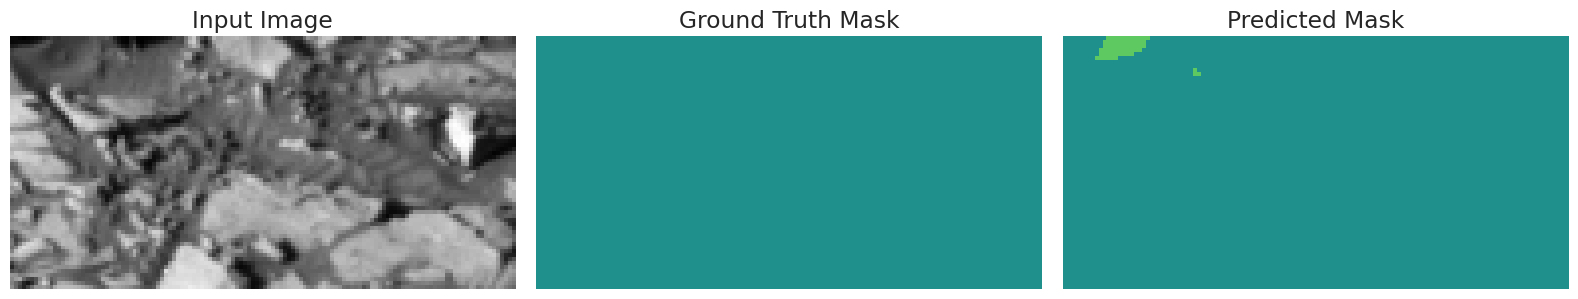

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 643ms/step - accuracy: 0.6500 - loss: 0.1797 - mean_iou: 0.5864 - val_accuracy: 0.6442 - val_loss: 0.1861 - val_mean_iou: 0.5652 - learning_rate: 5.0000e-04
Epoch 37/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 629ms/step - accuracy: 0.6501 - loss: 0.1794 - mean_iou: 0.5877 - val_accuracy: 0.6434 - val_loss: 0.1867 - val_mean_iou: 0.5654 - learning_rate: 5.0000e-04
Epoch 38/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 630ms/step - accuracy: 0.6512 - loss: 0.1791 - mean_iou: 0.5901 - val_accuracy: 0.6447 - val_loss: 0.1865 - val_mean_iou: 0.5683 - learning_rate: 5.0000e-04
Epoch 39/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.6515 - loss: 0.1788 - mean_iou: 0.5927
Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 629ms/step - accuracy: 0.6518 - loss: 0.1788 - mean_iou: 0.5928 - val_accuracy: 0.6427 - val_loss: 0.1866 - val_mean_iou: 0.5663 - learning_rate: 5.0000e-04
Epoch 40/200
47/47 ━━━━━━━━━━━━━━━━━━━

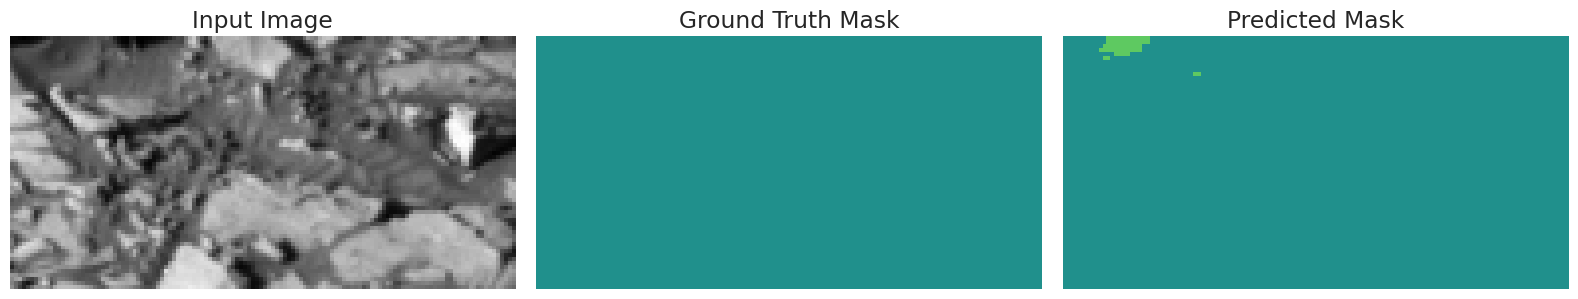

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 644ms/step - accuracy: 0.6577 - loss: 0.1775 - mean_iou: 0.6063 - val_accuracy: 0.6493 - val_loss: 0.1853 - val_mean_iou: 0.5737 - learning_rate: 2.5000e-04
Epoch 42/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step - accuracy: 0.6595 - loss: 0.1771 - mean_iou: 0.6094 - val_accuracy: 0.6501 - val_loss: 0.1850 - val_mean_iou: 0.5764 - learning_rate: 2.5000e-04
Epoch 43/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 634ms/step - accuracy: 0.6609 - loss: 0.1768 - mean_iou: 0.6124 - val_accuracy: 0.6508 - val_loss: 0.1848 - val_mean_iou: 0.5783 - learning_rate: 2.5000e-04
Epoch 44/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 631ms/step - accuracy: 0.6582 - loss: 0.1771 - mean_iou: 0.6075 - val_accuracy: 0.6501 - val_loss: 0.1851 - val_mean_iou: 0.5770 - learning_rate: 2.5000e-04
Epoch 45/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 633ms/step - accuracy: 0.6615 - loss: 0.1762 - mean_iou: 0.6121 - val_accuracy: 0.6503 - val_loss: 0.1854 - val_mean_iou: 0.5790 - learning_rate: 2.5000e-04
Epoch 46

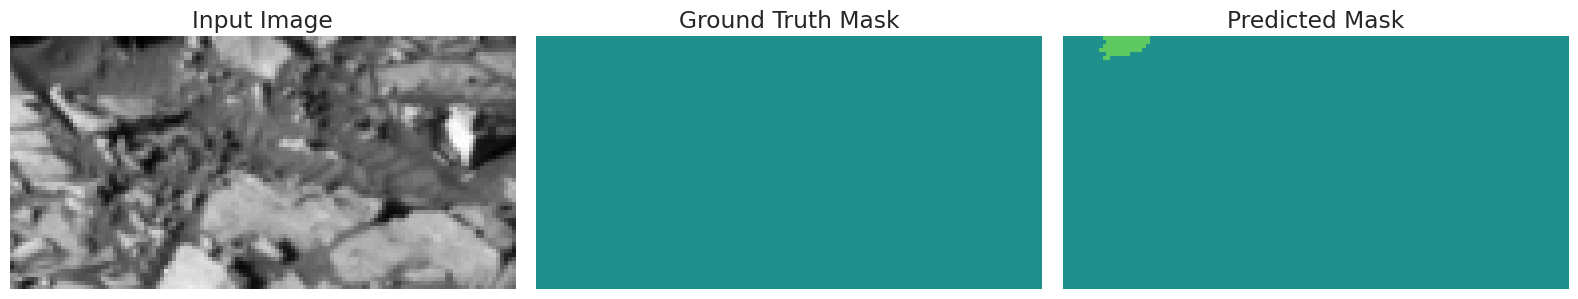

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 645ms/step - accuracy: 0.6629 - loss: 0.1761 - mean_iou: 0.6165 - val_accuracy: 0.6513 - val_loss: 0.1850 - val_mean_iou: 0.5812 - learning_rate: 2.5000e-04
Epoch 47/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 633ms/step - accuracy: 0.6643 - loss: 0.1757 - mean_iou: 0.6195 - val_accuracy: 0.6518 - val_loss: 0.1849 - val_mean_iou: 0.5823 - learning_rate: 2.5000e-04
Epoch 48/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.6652 - loss: 0.1754 - mean_iou: 0.6215
Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step - accuracy: 0.6656 - loss: 0.1754 - mean_iou: 0.6217 - val_accuracy: 0.6521 - val_loss: 0.1850 - val_mean_iou: 0.5833 - learning_rate: 2.5000e-04
Epoch 49/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 633ms/step - accuracy: 0.6668 - loss: 0.1750 - mean_iou: 0.6244 - val_accuracy: 0.6607 - val_loss: 0.1812 - val_mean_iou: 0.5938 - learning_rate: 1.2500e-04
Epoch 50/200
47/47 ━━━━━━━━━━━━━━━━━━━

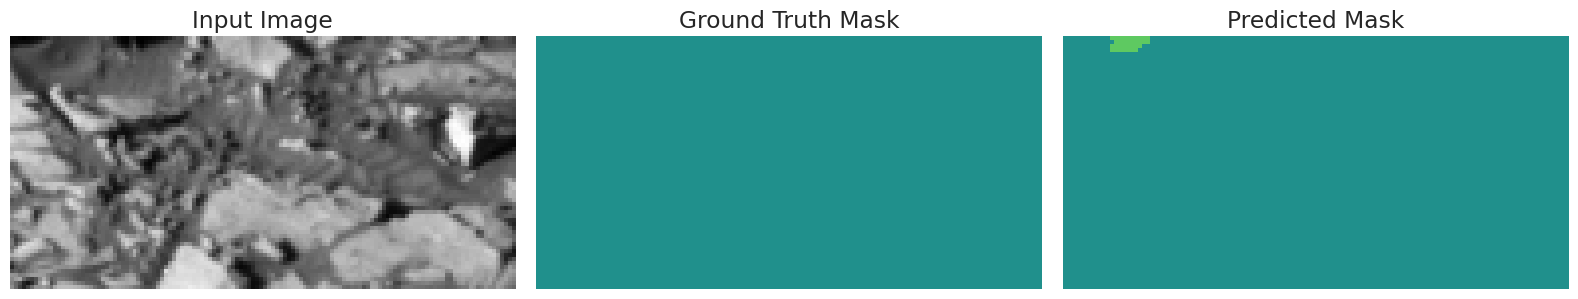

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 643ms/step - accuracy: 0.6646 - loss: 0.1748 - mean_iou: 0.6236 - val_accuracy: 0.6613 - val_loss: 0.1816 - val_mean_iou: 0.5947 - learning_rate: 1.2500e-04
Epoch 52/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 633ms/step - accuracy: 0.6662 - loss: 0.1744 - mean_iou: 0.6275 - val_accuracy: 0.6615 - val_loss: 0.1815 - val_mean_iou: 0.5952 - learning_rate: 1.2500e-04
Epoch 53/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 634ms/step - accuracy: 0.6675 - loss: 0.1740 - mean_iou: 0.6308 - val_accuracy: 0.6617 - val_loss: 0.1815 - val_mean_iou: 0.5955 - learning_rate: 1.2500e-04
Epoch 54/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.6681 - loss: 0.1737 - mean_iou: 0.6328
Epoch 54: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step - accuracy: 0.6685 - loss: 0.1737 - mean_iou: 0.6330 - val_accuracy: 0.6618 - val_loss: 0.1816 - val_mean_iou: 0.5953 - learning_rate: 1.2500e-04
Epoch 55/200
47/47 ━━━━━━━━━━━━━━━━━━━━

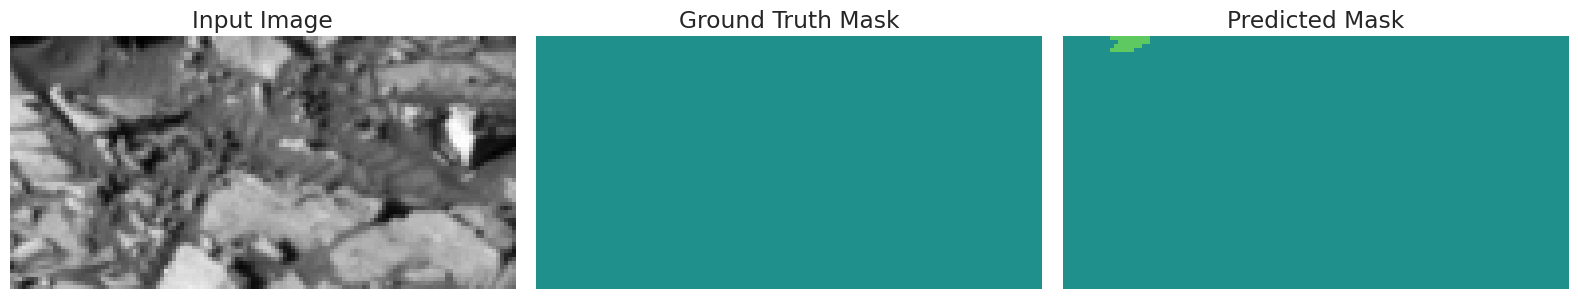

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 642ms/step - accuracy: 0.6730 - loss: 0.1731 - mean_iou: 0.6396 - val_accuracy: 0.6534 - val_loss: 0.1860 - val_mean_iou: 0.5843 - learning_rate: 6.2500e-05
Epoch 57/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 630ms/step - accuracy: 0.6729 - loss: 0.1731 - mean_iou: 0.6404 - val_accuracy: 0.6533 - val_loss: 0.1861 - val_mean_iou: 0.5839 - learning_rate: 6.2500e-05
Epoch 58/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 630ms/step - accuracy: 0.6732 - loss: 0.1729 - mean_iou: 0.6413 - val_accuracy: 0.6534 - val_loss: 0.1861 - val_mean_iou: 0.5838 - learning_rate: 6.2500e-05
Epoch 59/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.6732 - loss: 0.1728 - mean_iou: 0.6426
Epoch 59: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 629ms/step - accuracy: 0.6736 - loss: 0.1728 - mean_iou: 0.6428 - val_accuracy: 0.6535 - val_loss: 0.1861 - val_mean_iou: 0.5835 - learning_rate: 6.2500e-05
Epoch 60/200
47/47 ━━━━━━━━━━━━━━━━━━━

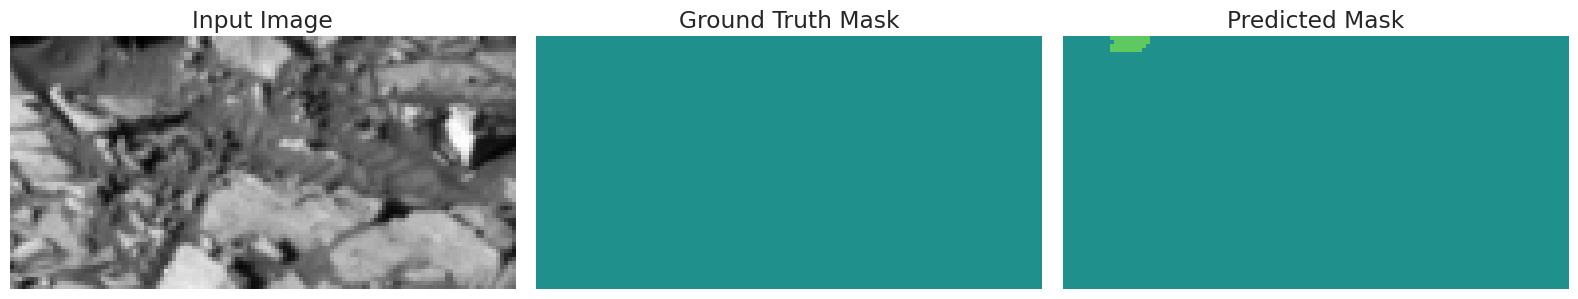

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 640ms/step - accuracy: 0.6751 - loss: 0.1719 - mean_iou: 0.6468 - val_accuracy: 0.6613 - val_loss: 0.1831 - val_mean_iou: 0.5943 - learning_rate: 3.1250e-05
Epoch 62/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 627ms/step - accuracy: 0.6755 - loss: 0.1718 - mean_iou: 0.6478 - val_accuracy: 0.6612 - val_loss: 0.1832 - val_mean_iou: 0.5941 - learning_rate: 3.1250e-05
Epoch 63/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 629ms/step - accuracy: 0.6759 - loss: 0.1717 - mean_iou: 0.6487 - val_accuracy: 0.6612 - val_loss: 0.1833 - val_mean_iou: 0.5939 - learning_rate: 3.1250e-05
Epoch 64/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.6758 - loss: 0.1717 - mean_iou: 0.6496
Epoch 64: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 629ms/step - accuracy: 0.6762 - loss: 0.1717 - mean_iou: 0.6498 - val_accuracy: 0.6612 - val_loss: 0.1834 - val_mean_iou: 0.5939 - learning_rate: 3.1250e-05
Epoch 65/200
47/47 ━━━━━━━━━━━━━━━━━━

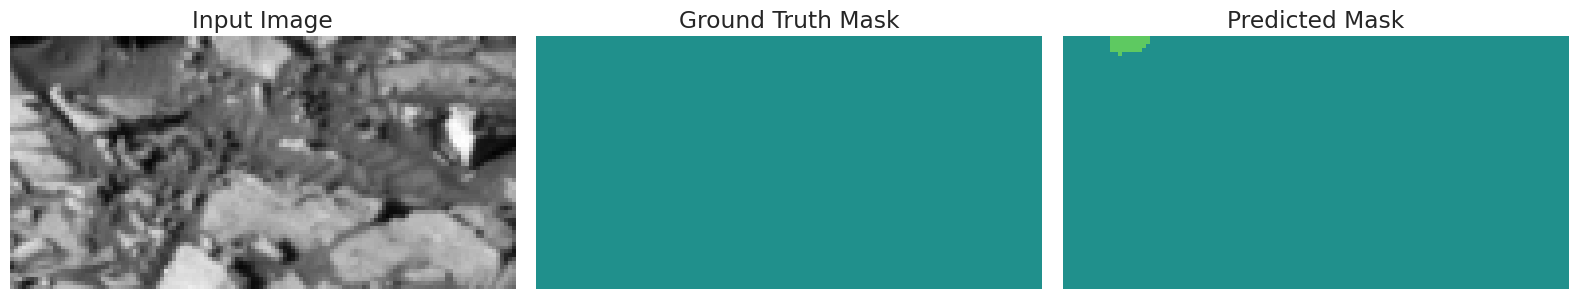

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 644ms/step - accuracy: 0.6780 - loss: 0.1713 - mean_iou: 0.6547 - val_accuracy: 0.6640 - val_loss: 0.1818 - val_mean_iou: 0.5983 - learning_rate: 1.5625e-05
Epoch 67/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 630ms/step - accuracy: 0.6782 - loss: 0.1712 - mean_iou: 0.6552 - val_accuracy: 0.6640 - val_loss: 0.1818 - val_mean_iou: 0.5982 - learning_rate: 1.5625e-05
Epoch 68/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step - accuracy: 0.6784 - loss: 0.1712 - mean_iou: 0.6557 - val_accuracy: 0.6640 - val_loss: 0.1818 - val_mean_iou: 0.5982 - learning_rate: 1.5625e-05
Epoch 69/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.6782 - loss: 0.1711 - mean_iou: 0.6561
Epoch 69: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 631ms/step - accuracy: 0.6786 - loss: 0.1711 - mean_iou: 0.6563 - val_accuracy: 0.6640 - val_loss: 0.1819 - val_mean_iou: 0.5980 - learning_rate: 1.5625e-05
Epoch 70/200
47/47 ━━━━━━━━━━━━━━━━━━━

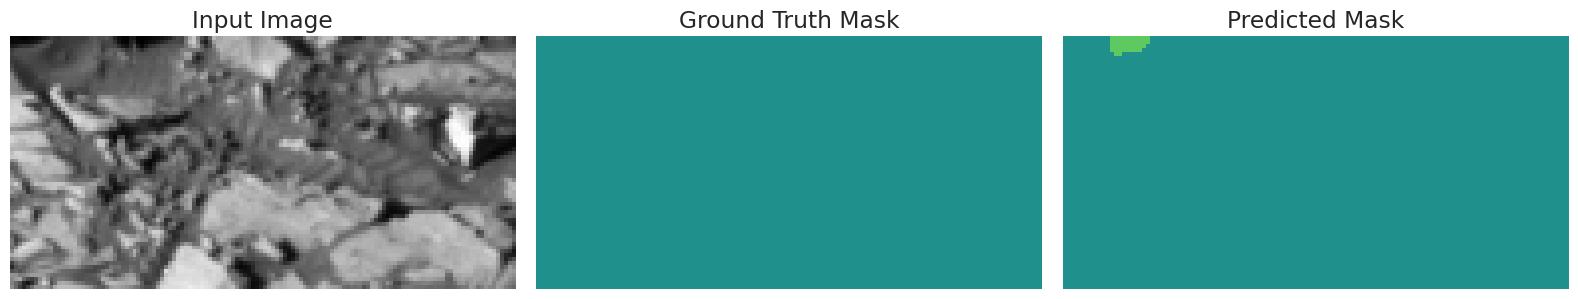

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 644ms/step - accuracy: 0.6797 - loss: 0.1709 - mean_iou: 0.6575 - val_accuracy: 0.6652 - val_loss: 0.1811 - val_mean_iou: 0.5996 - learning_rate: 7.8125e-06
Epoch 72/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step - accuracy: 0.6798 - loss: 0.1708 - mean_iou: 0.6580 - val_accuracy: 0.6652 - val_loss: 0.1811 - val_mean_iou: 0.5996 - learning_rate: 7.8125e-06
Epoch 73/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 633ms/step - accuracy: 0.6799 - loss: 0.1708 - mean_iou: 0.6583 - val_accuracy: 0.6652 - val_loss: 0.1811 - val_mean_iou: 0.5996 - learning_rate: 7.8125e-06
Epoch 74/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step - accuracy: 0.6800 - loss: 0.1708 - mean_iou: 0.6586 - val_accuracy: 0.6652 - val_loss: 0.1812 - val_mean_iou: 0.5995 - learning_rate: 7.8125e-06
Epoch 75/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.6798 - loss: 0.1708 - mean_iou: 0.6587
Epoch 75: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
47/47 ━━━━━━━━━━━━━━━━━━━

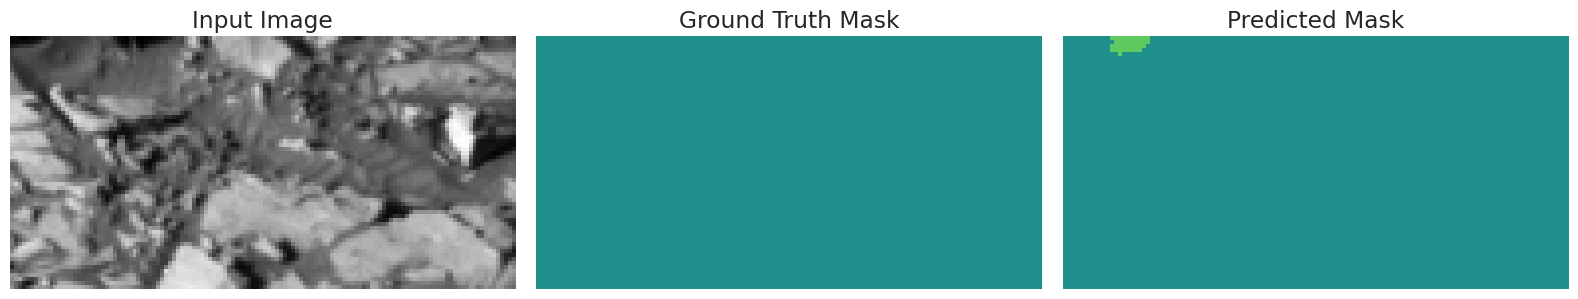

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 644ms/step - accuracy: 0.6805 - loss: 0.1707 - mean_iou: 0.6592 - val_accuracy: 0.6652 - val_loss: 0.1812 - val_mean_iou: 0.5994 - learning_rate: 3.9063e-06
Epoch 77/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 630ms/step - accuracy: 0.6806 - loss: 0.1706 - mean_iou: 0.6594 - val_accuracy: 0.6652 - val_loss: 0.1812 - val_mean_iou: 0.5994 - learning_rate: 3.9063e-06
Epoch 78/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step - accuracy: 0.6806 - loss: 0.1706 - mean_iou: 0.6595 - val_accuracy: 0.6652 - val_loss: 0.1812 - val_mean_iou: 0.5993 - learning_rate: 3.9063e-06
Epoch 79/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step - accuracy: 0.6807 - loss: 0.1706 - mean_iou: 0.6596 - val_accuracy: 0.6652 - val_loss: 0.1812 - val_mean_iou: 0.5994 - learning_rate: 3.9063e-06
Epoch 80/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.6804 - loss: 0.1706 - mean_iou: 0.6596
Epoch 80: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
47/47 ━━━━━━━━━━━━━━━━━━

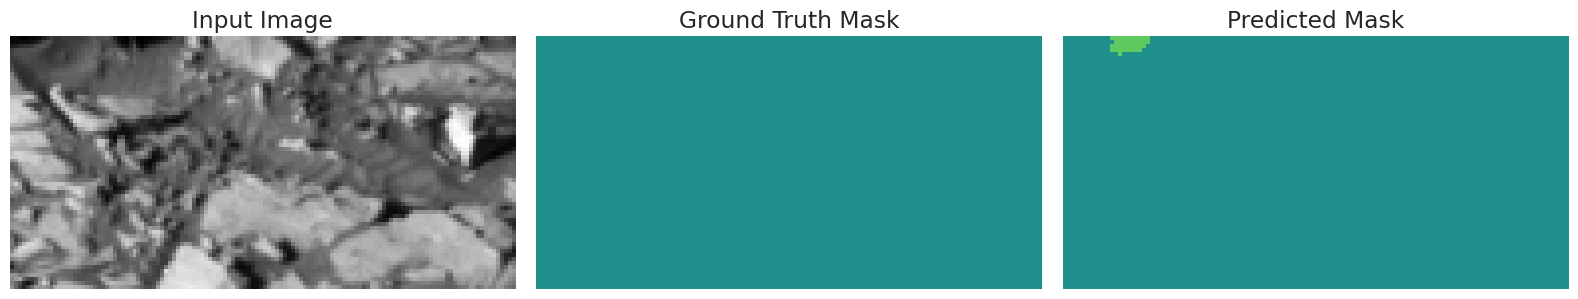

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 642ms/step - accuracy: 0.6809 - loss: 0.1706 - mean_iou: 0.6599 - val_accuracy: 0.6652 - val_loss: 0.1813 - val_mean_iou: 0.5993 - learning_rate: 1.9531e-06
Epoch 82/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 630ms/step - accuracy: 0.6809 - loss: 0.1706 - mean_iou: 0.6600 - val_accuracy: 0.6652 - val_loss: 0.1813 - val_mean_iou: 0.5993 - learning_rate: 1.9531e-06
Epoch 83/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 630ms/step - accuracy: 0.6810 - loss: 0.1705 - mean_iou: 0.6600 - val_accuracy: 0.6652 - val_loss: 0.1813 - val_mean_iou: 0.5993 - learning_rate: 1.9531e-06
Epoch 84/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 631ms/step - accuracy: 0.6810 - loss: 0.1705 - mean_iou: 0.6601 - val_accuracy: 0.6652 - val_loss: 0.1813 - val_mean_iou: 0.5993 - learning_rate: 1.9531e-06
Epoch 85/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.6806 - loss: 0.1705 - mean_iou: 0.6600
Epoch 85: ReduceLROnPlateau reducing learning rate to 1e-06.
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step

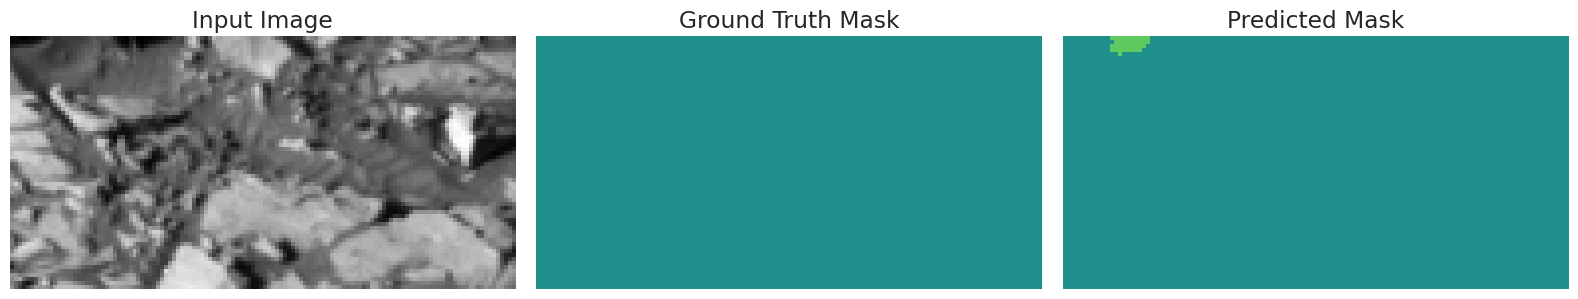

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 641ms/step - accuracy: 0.6811 - loss: 0.1705 - mean_iou: 0.6602 - val_accuracy: 0.6651 - val_loss: 0.1813 - val_mean_iou: 0.5993 - learning_rate: 1.0000e-06
Epoch 87/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 631ms/step - accuracy: 0.6811 - loss: 0.1705 - mean_iou: 0.6603 - val_accuracy: 0.6651 - val_loss: 0.1813 - val_mean_iou: 0.5993 - learning_rate: 1.0000e-06
Epoch 88/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step - accuracy: 0.6811 - loss: 0.1705 - mean_iou: 0.6603 - val_accuracy: 0.6651 - val_loss: 0.1813 - val_mean_iou: 0.5993 - learning_rate: 1.0000e-06
Epoch 89/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step - accuracy: 0.6811 - loss: 0.1705 - mean_iou: 0.6603 - val_accuracy: 0.6651 - val_loss: 0.1813 - val_mean_iou: 0.5993 - learning_rate: 1.0000e-06
Epoch 90/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step - accuracy: 0.6811 - loss: 0.1705 - mean_iou: 0.6603 - val_accuracy: 0.6651 - val_loss: 0.1813 - val_mean_iou: 0.5992 - learning_rate: 1.0000e-06
Epoch 91

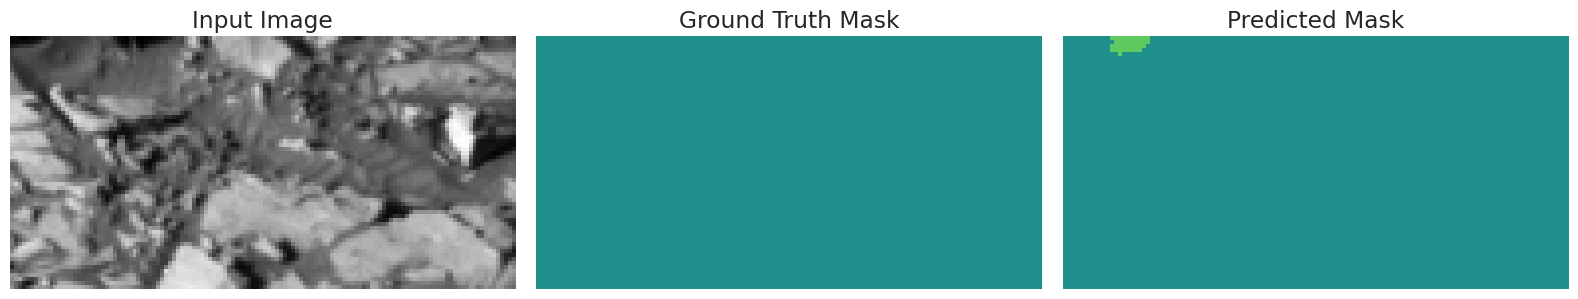

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 641ms/step - accuracy: 0.6812 - loss: 0.1705 - mean_iou: 0.6603 - val_accuracy: 0.6651 - val_loss: 0.1813 - val_mean_iou: 0.5992 - learning_rate: 1.0000e-06
Epoch 92/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step - accuracy: 0.6812 - loss: 0.1705 - mean_iou: 0.6603 - val_accuracy: 0.6651 - val_loss: 0.1813 - val_mean_iou: 0.5992 - learning_rate: 1.0000e-06


In [18]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, viz_callback],
    verbose=1
).history

In [19]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_5_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Final validation Mean Intersection Over Union: 59.96%


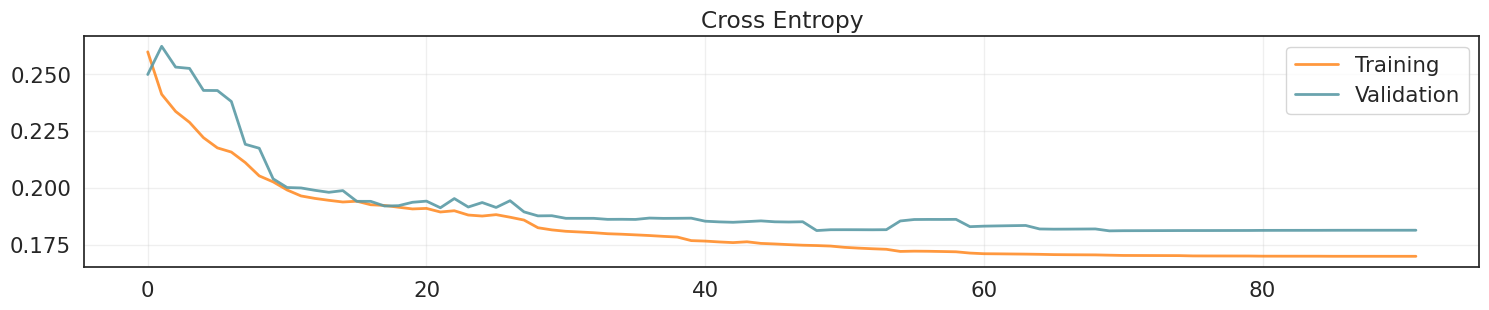

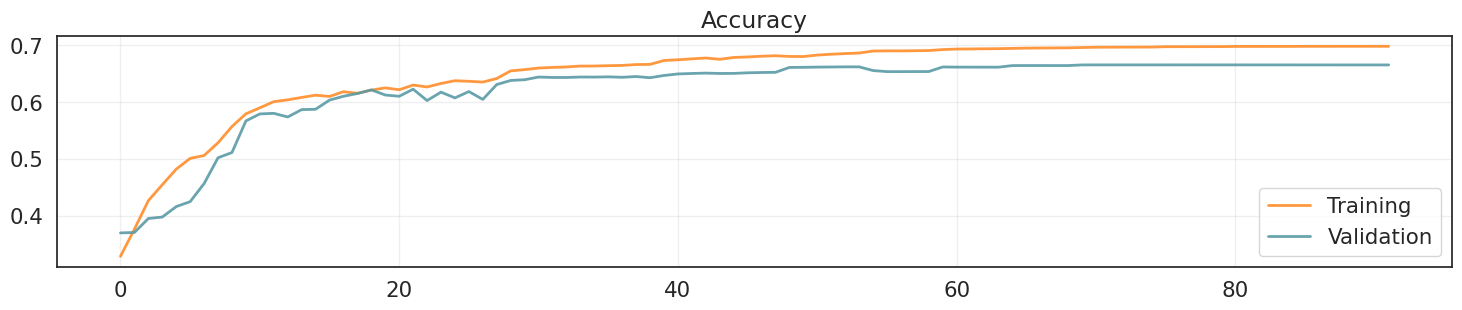

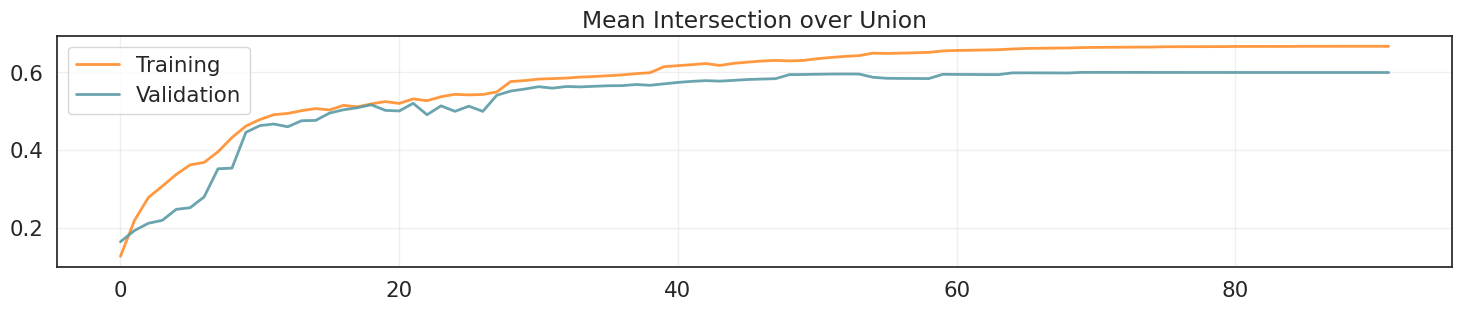

In [20]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🕹️ Use the Model - Make Inference

In [21]:
# path
model_path = "/kaggle/working/UNet_5_59.96.keras"

# Create a dictionary mapping the names of custom layers to their classes/functions
custom_objects = {
    'TransformerBlock': TransformerBlock,
}

# Load the model
try:
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects, compile=False)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully.


In [23]:
model.compile(optimizer="adam",
              loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, dice_weight=0.2, focal_weight=0.8),
              metrics=["accuracy",
                       MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])])


In [24]:
test_loss, test_accuracy, test_mean_iou = model.evaluate(X_our_test, y_our_test, verbose=1)
print(f"Loss: {test_loss}\nAccuracy: {test_accuracy}\nMean Over Union: {test_mean_iou}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 426ms/step - accuracy: 0.6416 - loss: 0.1836 - mean_iou: 0.6328
Loss: 0.18387112021446228
Accuracy: 0.6512874960899353
Mean Over Union: 0.6189083456993103


In [25]:
def calculate_class_iou(y_true, y_pred, num_classes):
    class_iou = {}

    for class_idx in range(num_classes):
        # Crea una maschera binaria per la classe
        true_mask = (y_true == class_idx).astype(int)
        pred_mask = (y_pred == class_idx).astype(int)

        # Calcola l'intersezione e l'unione
        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        # Calcola IoU, evitando la divisione per zero
        iou = intersection / union if union > 0 else 0.0
        class_iou[class_idx] = iou

    return class_iou

In [26]:
# Compute the prediction
y_pred = model.predict(X_our_test, batch_size=10)
y_pred_labels = tf.math.argmax(y_pred, axis=-1).numpy()

# Compute IoU per class
iou_per_class = calculate_class_iou(y_our_test, y_pred_labels, num_classes)

# Print the results
for class_idx, iou in iou_per_class.items():
    print(f"Class {class_idx}: IoU = {round(iou, 4)}")

I0000 00:00:1734200427.059473    5864 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 768 bytes spill stores, 768 bytes spill loads

I0000 00:00:1734200427.886513    5862 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 768 bytes spill stores, 768 bytes spill loads



51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step
Class 0: IoU = 0.0
Class 1: IoU = 0.6518
Class 2: IoU = 0.557
Class 3: IoU = 0.5548
Class 4: IoU = 0.1204


In [27]:
def calculate_metrics_per_class(y_true, y_pred, num_classes):
    metrics = {}

    for class_idx in range(num_classes):
        # Create binary masks for the current class
        true_binary = (y_true == class_idx).flatten()
        pred_binary = (y_pred == class_idx).flatten()

        # Compute precision, recall, and F1-score
        precision = precision_score(true_binary, pred_binary, zero_division=0)
        recall = recall_score(true_binary, pred_binary, zero_division=0)
        f1 = f1_score(true_binary, pred_binary, zero_division=0)

        # Store the metrics for the current class
        metrics[class_idx] = {
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        }

    return metrics

In [28]:
# Compute metrics for each class
metrics_per_class = calculate_metrics_per_class(y_our_test, y_pred_labels, num_classes)

# Print the results for each class
for class_idx, metrics in metrics_per_class.items():
    print(f"Class {class_idx}:")
    print(f"  Precision = {round(metrics['Precision'], 4)}")
    print(f"  Recall = {round(metrics['Recall'], 4)}")
    print(f"  F1-score = {round(metrics['F1-score'], 4)}")

Class 0:
  Precision = 0.0
  Recall = 0.0
  F1-score = 0.0
Class 1:
  Precision = 0.7123
  Recall = 0.8849
  F1-score = 0.7892
Class 2:
  Precision = 0.601
  Recall = 0.8839
  F1-score = 0.7155
Class 3:
  Precision = 0.6193
  Recall = 0.842
  F1-score = 0.7137
Class 4:
  Precision = 0.2577
  Recall = 0.1843
  F1-score = 0.2149


## 📊 Prepare Your Submission


In [29]:
# Percorso del file del modello
model_path = "/kaggle/working/UNet_5_59.96.keras"

# Carica il modello
model = tf.keras.models.load_model(model_path, compile=False)
print("Model loaded successfully.")

Model loaded successfully.


In [30]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step

I0000 00:00:1734200668.229341    5907 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 768 bytes spill stores, 768 bytes spill loads

I0000 00:00:1734200669.960102    5905 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 768 bytes spill stores, 768 bytes spill loads



314/314 ━━━━━━━━━━━━━━━━━━━━ 81s 247ms/step
Predictions shape: (10022, 64, 128)


In [31]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [32]:
# Create and save the CSV submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)  # Convert predictions to DataFrame
submission_df.to_csv(f"/kaggle/working/{submission_filename}", index=False)

print(f"Submission file saved: {submission_filename}")

Submission file saved: submission_UNet_5_59.96.csv
